In [1]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-07-20 18:08:12.803606: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-20 18:08:14.189019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 18:08:14.992199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [2]:
import polars
import matplotlib.pyplot as plt
import torchaudio

import helpers.input_processor as ip

/home/andrecox/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "data/raw_training/training_data/"
df = ip.ingest_data(data_dir)

Reading from .txt files in data/raw_training/training_data/: 100%|██████████| 942/942 [00:00<00:00, 12519.24it/s]


In [4]:
# output metadata of first audio file
metadata = torchaudio.info(data_dir + df['audio_file'][0][0])
print(metadata)

AudioMetaData(sample_rate=4000, num_frames=41152, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [5]:
# loop through the dataset and create a list of audio paths
audioPaths = []
labels = []
for i in range(len(df)):
    for j in range(len(df['audio_file'][i])):
        audioPaths.append(data_dir + df['audio_file'][i][j])
        # check if there is a murmur at the recording location
        murmur = False
        for k in df['murmur_locations'][i]:
            if k in df['audio_file'][i][j]:
                labels.append(1)
                murmur = True
                break
        if murmur == False:
            labels.append(0)



print("Audio path number: ", len(audioPaths))
print("Label number: ", len(labels))

Audio path number:  3163
Label number:  3163


In [6]:
import random
import sys
import copy

# make the positive's and negative's equal
num_pos = 0
num_neg = 0

for i in range(len(labels)):

    if labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

balanced_labels = copy.deepcopy(labels)
balanced_audio_paths = copy.deepcopy(audioPaths)


##### Remove data from the dataset #####

while num_pos != num_neg:
    # get ratio of positive to negative
    ratio = (num_pos / num_neg) * 100.0

    sys.stdout.flush()
    sys.stdout.write("\rRatio: %s" % ratio + "%")

    if num_pos < num_neg:
        foundNeg = False
        while foundNeg == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 0:
                balanced_labels.pop(idx)
                balanced_audio_paths.pop(idx)
                foundNeg = True
                num_neg -= 1
    else:
        foundPos = False
        while foundPos == False:
            idx = random.randint(0, len(balanced_labels) - 1)
            if balanced_labels[idx] == 1:
                balanced_labels.pop(idx)
                balanced_audio_paths.pop(idx)
                foundPos = True
                num_pos -= 1


### Add data to the balanced dataset ###

#while num_pos != num_neg:
#    # get ratio of positive to negative
#    ratio = (num_pos / num_neg) * 100.0
#
#    sys.stdout.flush()
#    sys.stdout.write("\rRatio: %s" % ratio + "%")
#
#    if num_pos > num_neg:
#        foundNeg = False
#        while foundNeg == False:
#            idx = random.randint(0, len(balanced_labels) - 1)
#            if balanced_labels[idx] == 0:
#                balanced_labels.append(0)
#                balanced_audio_paths.append(balanced_audio_paths[idx])
#                foundNeg = True
#                num_neg += 1
#    else:
#        foundPos = False
#        while foundPos == False:
#            idx = random.randint(0, len(balanced_labels) - 1)
#            if balanced_labels[idx] == 1:
#                balanced_labels.append(1)
#                balanced_audio_paths.append(balanced_audio_paths[idx])
#                foundPos = True
#                num_pos += 1


Ratio: 99.8%079840319361%%

In [7]:
# check how many positive and negative examples are in the dataset
num_pos = 0
num_neg = 0
for i in range(len(balanced_labels)):
    if balanced_labels[i] == 1:
        num_pos += 1
    else:
        num_neg += 1

print("Positive examples: ", num_pos)
print("Negative examples: ", num_neg)
print("Total examples: ", num_pos + num_neg)

print("Percentage of positive examples: ", (num_pos / (num_pos + num_neg)) * 100.0, "%")

Positive examples:  499
Negative examples:  499
Total examples:  998
Percentage of positive examples:  50.0 %


In [8]:
# split audio paths and labels into training and testing sets shuffled
import random
zipped = list(zip(balanced_audio_paths, balanced_labels))
random.shuffle(zipped)
shuffled_audio_paths, shuffled_labels = zip(*zipped)

train_audio_paths = shuffled_audio_paths[:int(len(shuffled_audio_paths) * 0.8)]
train_labels = shuffled_labels[:int(len(shuffled_labels) * 0.8)]

test_audio_paths = shuffled_audio_paths[int(len(shuffled_audio_paths) * 0.8):]
test_labels = shuffled_labels[int(len(shuffled_labels) * 0.8):]

In [9]:
print("Training audio paths: ", len(train_audio_paths))
print("Training labels: ", len(train_labels))
print("Testing audio paths: ", len(test_audio_paths))
print("Testing labels: ", len(test_labels))

Training audio paths:  798
Training labels:  798
Testing audio paths:  200
Testing labels:  200


In [10]:
import numpy as np
import torch
import torchaudio

def batch_generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            ids_batch = image_paths[start:end]
            for id in ids_batch:
                waveform = torchaudio.load(id)[0]
                spectrogram = torchaudio.transforms.Spectrogram()(waveform)
                spectrogram = spectrogram.log2()
                spectrogram = spectrogram / spectrogram.abs().max()
            
                spectrogram = spectrogram.numpy()
                
                if spectrogram.shape[2] > 200:
                    x_start = random.randint(0, spectrogram.shape[2] - 200)
                else:
                    x_start = 0
                x_end = x_start + 200

                spectrogram = spectrogram[:, :, :200]

                # if the spectrogram is less that 200 pad it with zeros
                if spectrogram.shape[2] < 200:
                    spectrogram = np.pad(spectrogram, ((0, 0), (0, 0), (0, 200 - spectrogram.shape[2])), 'constant')
                # rotate the spectrogram
                #spectrogram = np.rot90(spectrogram, k=3)
                x_batch.append(np.rot90(spectrogram.T, k=3))
                y_batch.append(labels[image_paths.index(id)])
                
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch


Time to generate batch:  158.48374366760254 ms


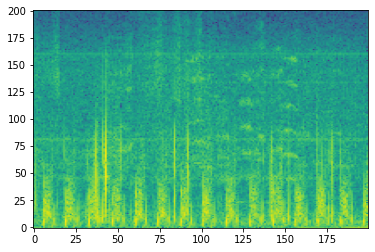

In [11]:
# display the first image and steering angle
import matplotlib.pyplot as plt
import time 
start = time.time()
x_batch, y_batch = next(batch_generator(train_audio_paths, train_labels, 32))
end = time.time()
print("Time to generate batch: ", (end - start) * 1000, "ms")
plt.imshow((x_batch[2]), aspect='auto', origin='lower')

In [12]:
print(x_batch[0].shape)

(201, 200, 1)


In [13]:
batch_size = 32

train_gen = batch_generator(train_audio_paths, train_labels, batch_size=batch_size)
test_gen = batch_generator(test_audio_paths, test_labels, batch_size=batch_size)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

imageGenerator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

imageGenerator.fit(next(batch_generator(train_audio_paths, train_labels, batch_size=batch_size)))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 32) + inhomogeneous part.

In [21]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Conv2D, Dropout

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model
model.add(InputLayer(input_shape=(201, 200, 1)))
# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
 

In [22]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.0001)

model.compile(optimizer=optimizer, loss='bce', metrics=['accuracy']) # we will keep track of the mean squared error using mse
hist = model.fit(train_gen, steps_per_epoch=np.ceil(float(len(train_labels)) / float(batch_size)), validation_data=test_gen, validation_steps=25, epochs=25) # changing the number of epochs may help the model!

Epoch 1/25
25/25 [==============================] - 10s 405ms/step - loss: 0.7000 - accuracy: 0.5501 - val_loss: 0.6537 - val_accuracy: 0.6023
Epoch 2/25
25/25 [==============================] - 10s 398ms/step - loss: 0.6546 - accuracy: 0.6253 - val_loss: 0.7023 - val_accuracy: 0.5696
Epoch 3/25
25/25 [==============================] - 10s 406ms/step - loss: 0.6350 - accuracy: 0.6404 - val_loss: 0.6562 - val_accuracy: 0.5495
Epoch 4/25
25/25 [==============================] - 9s 392ms/step - loss: 0.5978 - accuracy: 0.6617 - val_loss: 0.6541 - val_accuracy: 0.5568
Epoch 5/25
25/25 [==============================] - 9s 389ms/step - loss: 0.5778 - accuracy: 0.6867 - val_loss: 0.6770 - val_accuracy: 0.5597
Epoch 6/25
25/25 [==============================] - 10s 396ms/step - loss: 0.5646 - accuracy: 0.7018 - val_loss: 0.6795 - val_accuracy: 0.5687
Epoch 7/25
25/25 [==============================] - 10s 401ms/step - loss: 0.5366 - accuracy: 0.7193 - val_loss: 0.6284 - val_accuracy: 0.6580
E

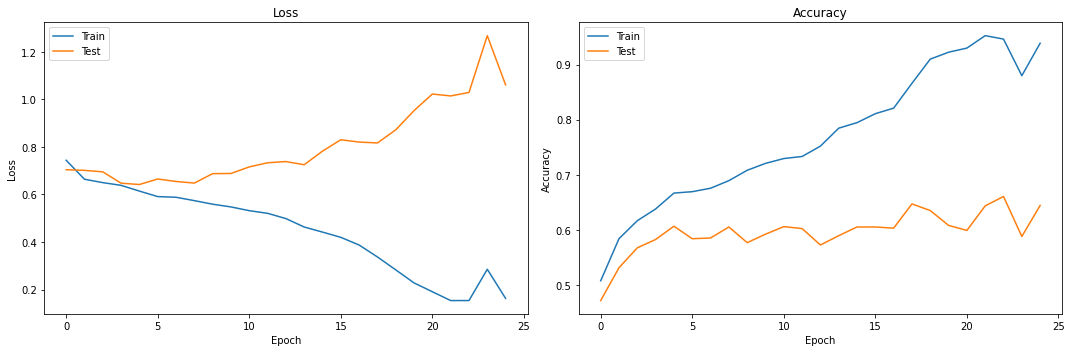

In [20]:
# create a graph of the history of the model
import matplotlib.pyplot as plt

# sublot 1 loss subplot 2 accuracy
ax1 = plt.subplot(121)
ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# subplot 2 accuracy
ax2 = plt.subplot(122)
ax2.plot(hist.history['accuracy'])
ax2.plot(hist.history['val_accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

# set fig height and width
fig = plt.gcf()
fig.set_size_inches(15, 5)

#tight_layout() makes sure the plot fits in the figure
plt.tight_layout()


plt.show()
